In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
import requests
import io
import matplotlib.pyplot as plt

In [ ]:
#Loading the dataset from GitHub link
def load_data_from_github(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = pd.read_csv(io.StringIO(response.text))
        return data['English words/sentences'].values, data['French words/sentences'].values
    else:
        print("Failed to retrieve the file. Check the URL.")
        return None, None

# Preprocess text (lowercase, remove non-alphanumeric)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text


In [ ]:
#Preparing dataset
def prepare_data(english_texts, french_texts):
    english_texts = [preprocess_text(text) for text in english_texts]
    french_texts = [preprocess_text(text) for text in french_texts]

    #Tokenization
    english_tokenizer = Tokenizer(filters='')
    french_tokenizer = Tokenizer(filters='')

    english_tokenizer.fit_on_texts(english_texts)
    french_tokenizer.fit_on_texts(french_texts)

    english_sequences = english_tokenizer.texts_to_sequences(english_texts)
    french_sequences = french_tokenizer.texts_to_sequences(french_texts)

    #Padding
    max_len_english = max(len(seq) for seq in english_sequences)
    max_len_french = max(len(seq) for seq in french_sequences)

    english_sequences = pad_sequences(english_sequences, maxlen=max_len_english, padding='post')
    french_sequences = pad_sequences(french_sequences, maxlen=max_len_french, padding='post')

    vocab_size_english = len(english_tokenizer.word_index) + 1
    vocab_size_french = len(french_tokenizer.word_index) + 1

    return english_sequences, french_sequences, max_len_english, max_len_french, vocab_size_english, vocab_size_french

In [ ]:
#Loading the data
url = "https://raw.githubusercontent.com/Kushal-Chandani/NLP-Homeworks/main/Homework3/Data/eng-french.csv"
english_texts, french_texts = load_data_from_github(url)

#Preparing the data
english_sequences, french_sequences, max_len_english, max_len_french, vocab_size_english, vocab_size_french = prepare_data(english_texts, french_texts)

In [ ]:
#Spliting the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(english_sequences, french_sequences, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
#Now we Ensure all input sequences are the same length by adjusting padding
max_decoder_seq_length = max_len_french - 1 

#Model parameters are set
embedding_dim = 256
lstm_units = 512

#Encoder model
encoder_inputs = Input(shape=(max_len_english,))
encoder_embedding = Embedding(input_dim=vocab_size_english, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Decoder model
decoder_inputs = Input(shape=(max_decoder_seq_length,))
decoder_embedding = Embedding(input_dim=vocab_size_french, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_french, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#Complete model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Training the model with teacher forcing
y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)

In [ ]:
history = model.fit(
    [X_train, y_train[:, :-1]], y_train[:, 1:],
    batch_size=64,
    epochs=3,
    validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:])
)

Epoch 1/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 393s 176ms/step - accuracy: 0.8968 - loss: 5.1012 - val_accuracy: 0.9268 - val_loss: 3.2421
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 441s 177ms/step - accuracy: 0.9318 - loss: 2.8688 - val_accuracy: 0.9415 - val_loss: 2.4315
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 388s 177ms/step - accuracy: 0.9474 - loss: 1.9950 - val_accuracy: 0.9503 - val_loss: 2.0188


In [ ]:
#Evaluating the model on the test set
y_test = np.expand_dims(y_test, -1)
model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:])

220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9505 - loss: 2.0119


[2.01857590675354, 0.9498887658119202]

In [ ]:
#Saving the model
model.save('english_french_rnn_model.h5')

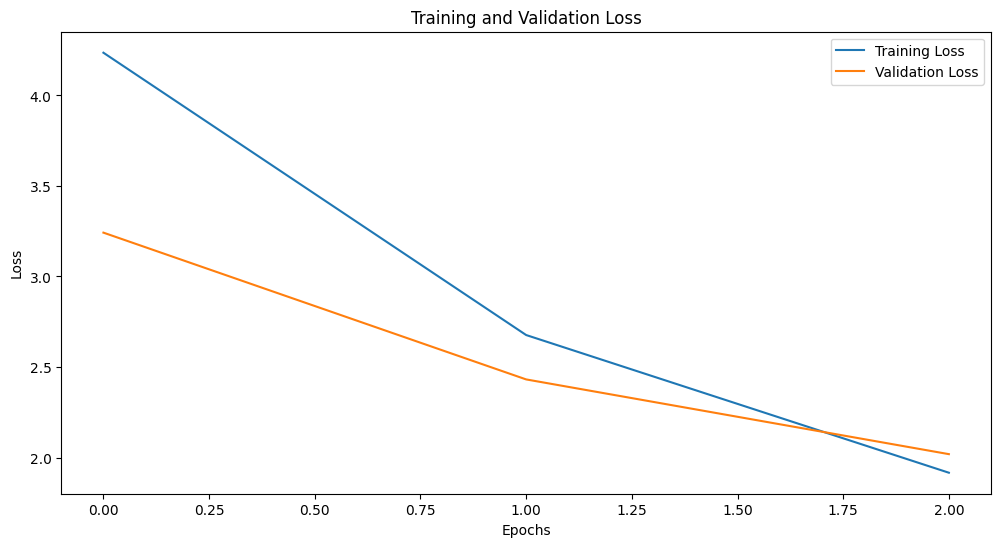

In [ ]:
#Plotting training Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

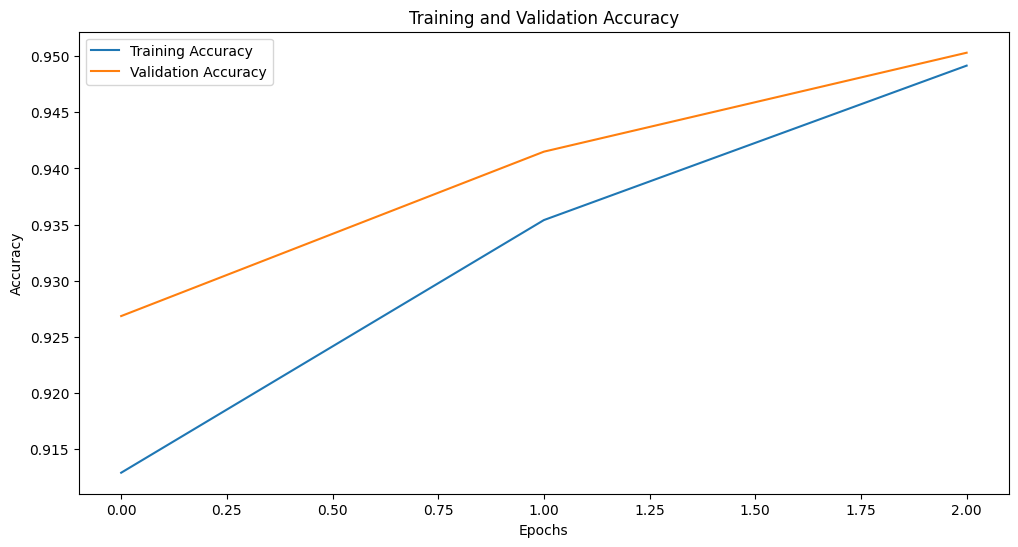

In [ ]:
# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 47)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 60)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 47, 256)        │      3,612,928 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 47)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 60, 256)        │      5,169,408 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,574,912 │ embedding[0][0],       │
│                           │ 512), (None, 512)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 512),      │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 60, 20193)      │     10,359,009 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 66,873,509 (255.10 MB)

 Trainable params: 22,291,169 (85.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,582,340 (170.07 MB)

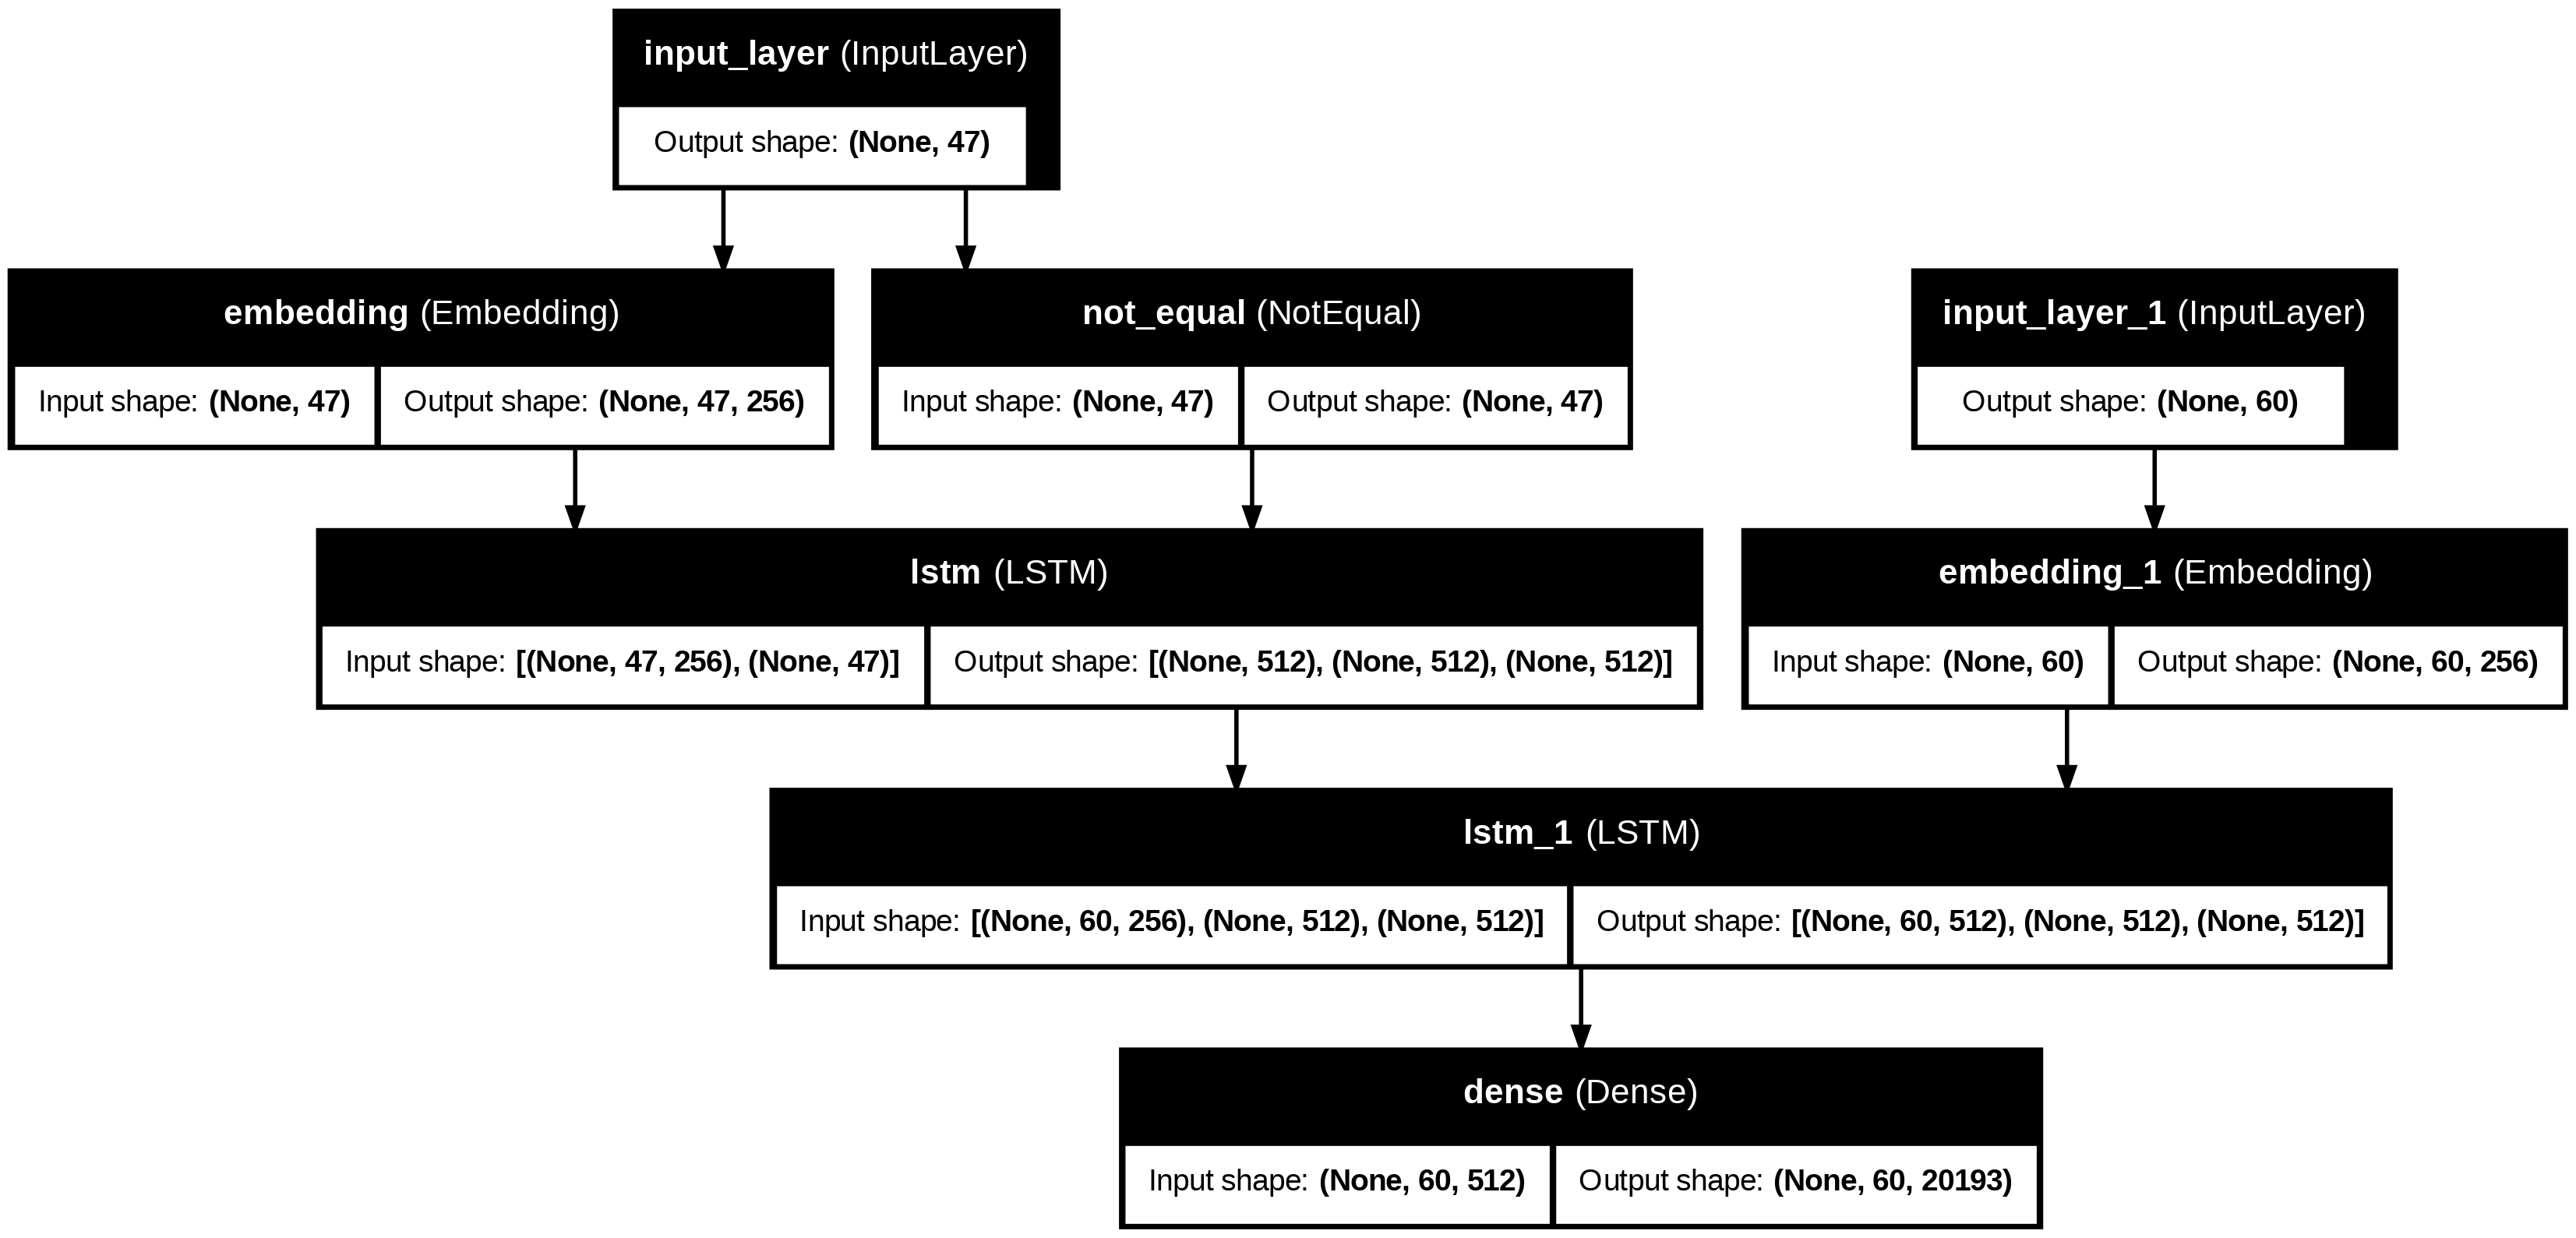

In [ ]:
from tensorflow.keras.utils import plot_model

#Saving the plot to a file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
import gc
from nltk.translate.bleu_score import sentence_bleu

#Define encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

#Define decoder model for inference
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

#Function to calculate BLEU score for the first 1000 rows of the test set
def calculate_bleu_score(encoder_model, decoder_model, english_sequences, french_sequences, french_tokenizer, max_len_french):
    bleu_scores = []

    for i in range(1000):
        input_seq = english_sequences[i:i+1]
        states_value = encoder_model.predict(input_seq)  # Get the encoder states

        #Creating an empty target sequence of length 1 for the decoder
        target_seq = np.zeros((1, 1))
        decoded_sentence = []

        #Initialization of decoding process
        for _ in range(max_len_french - 1):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = french_tokenizer.index_word.get(sampled_token_index, '')

            # End condition
            if sampled_word == '':
                break

            decoded_sentence.append(sampled_word)

            # Update target sequence and states
            target_seq[0, 0] = sampled_token_index
            states_value = [h, c]

        # Join predicted words to form the sentence
        predicted_sentence = ' '.join(decoded_sentence)

        # Get the reference sentence
        reference_sentence = [french_tokenizer.index_word.get(idx, '') for idx in french_sequences[i] if idx > 0]

        # Calculate BLEU score for this sentence
        bleu_score = sentence_bleu([reference_sentence], decoded_sentence)
        bleu_scores.append(bleu_score)

    # Calculate average BLEU score for the first 50 sentences
    avg_bleu_score = np.mean(bleu_scores)
    print(f'Average BLEU score for first 1000 samples: {avg_bleu_score:.4f}')

    # Clear memory to manage RAM efficiently
    del bleu_scores, input_seq, target_seq, decoded_sentence, output_tokens
    gc.collect()

# Prepare tokenizers and data, then call BLEU score function
english_sequences, french_sequences, max_len_english, max_len_french, vocab_size_english, vocab_size_french = prepare_data(english_texts, french_texts)

# Re-fit tokenizers on the loaded texts
english_tokenizer = Tokenizer(filters='')
french_tokenizer = Tokenizer(filters='')
english_tokenizer.fit_on_texts(english_texts)
french_tokenizer.fit_on_texts(french_texts)

calculate_bleu_score(encoder_model, decoder_model, english_sequences, french_sequences, french_tokenizer, max_len_french)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━